In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt


# Load and Explore the Dataset

In [3]:
data = pd.read_csv('/Users/jmyao/Desktop/datasets/credit_risk_dataset.csv')

In [4]:
# Inspect the dataset
data.shape

(32581, 12)

In [5]:
data.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


In [6]:
data.describe()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length
count,32581.000000,3.258100e+04,31686.000000,32581.000000,29465.000000,32581.000000,32581.000000,32581.000000
mean,27.734600,6.607485e+04,4.789686,9589.371106,11.011695,0.218164,0.170203,5.804211
std,6.348078,6.198312e+04,4.142630,6322.086646,3.240459,0.413006,0.106782,4.055001
min,20.000000,4.000000e+03,0.000000,500.000000,5.420000,0.000000,0.000000,2.000000
25%,23.000000,3.850000e+04,2.000000,5000.000000,7.900000,0.000000,0.090000,3.000000
50%,26.000000,5.500000e+04,4.000000,8000.000000,10.990000,0.000000,0.150000,4.000000
75%,30.000000,7.920000e+04,7.000000,12200.000000,13.470000,0.000000,0.230000,8.000000
max,144.000000,6.000000e+06,123.000000,35000.000000,23.220000,1.000000,0.830000,30.000000


# Data Cleaning

In [8]:
data.isnull().sum()

person_age                       0
person_income                    0
person_home_ownership            0
person_emp_length              895
loan_intent                      0
loan_grade                       0
loan_amnt                        0
loan_int_rate                 3116
loan_status                      0
loan_percent_income              0
cb_person_default_on_file        0
cb_person_cred_hist_length       0
dtype: int64

The dataset contains missing values in `person_emp_length` and `loan_int_rate`, which are critical features for loan evaluation. To ensure data integrity, I will fill person_emp_length with its median to handle potential outliers and loan_int_rate with its mean, as interest rates are typically evenly distributed.

In [10]:
# I use the median because employment length may have uneven distribution
data['person_emp_length'] = data['person_emp_length'].fillna(data['person_emp_length'].median())

# I Use the mean because interest rates are usually evenly distributed
data['loan_int_rate'] = data['loan_int_rate'].fillna(data['loan_int_rate'].mean())


In [11]:
# Verify that there are no more null values in the relevant columns
print(data[['person_emp_length', 'loan_int_rate']].isnull().sum())


person_emp_length    0
loan_int_rate        0
dtype: int64


In [12]:
data.dtypes

person_age                      int64
person_income                   int64
person_home_ownership          object
person_emp_length             float64
loan_intent                    object
loan_grade                     object
loan_amnt                       int64
loan_int_rate                 float64
loan_status                     int64
loan_percent_income           float64
cb_person_default_on_file      object
cb_person_cred_hist_length      int64
dtype: object

I want to use one-hot encoding with `pd.get_dummies()` to convert categorical variables (`person_home_ownership`, `loan_intent`, `loan_grade`, and `cb_person_default_on_file`) into numeric columns, enabling machine learning models like logistic regression and decision tree to process them effectively.

In [14]:
# Identify and encode categorical columns
categorical_columns = ['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file']

# Use one-hot encoding for these columns
data = pd.get_dummies(data, columns=categorical_columns, drop_first=True)

# Check the data types to ensure no categorical variables are still in the dataset
data.dtypes

person_age                       int64
person_income                    int64
person_emp_length              float64
loan_amnt                        int64
loan_int_rate                  float64
loan_status                      int64
loan_percent_income            float64
cb_person_cred_hist_length       int64
person_home_ownership_OTHER       bool
person_home_ownership_OWN         bool
person_home_ownership_RENT        bool
loan_intent_EDUCATION             bool
loan_intent_HOMEIMPROVEMENT       bool
loan_intent_MEDICAL               bool
loan_intent_PERSONAL              bool
loan_intent_VENTURE               bool
loan_grade_B                      bool
loan_grade_C                      bool
loan_grade_D                      bool
loan_grade_E                      bool
loan_grade_F                      bool
loan_grade_G                      bool
cb_person_default_on_file_Y       bool
dtype: object

In [15]:
# Add new debt-to-income ratio feature to dataset
data['debt_to_income_ratio'] = data['loan_amnt'] / data['person_income']

In [16]:
data.head()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length,person_home_ownership_OTHER,person_home_ownership_OWN,...,loan_intent_PERSONAL,loan_intent_VENTURE,loan_grade_B,loan_grade_C,loan_grade_D,loan_grade_E,loan_grade_F,loan_grade_G,cb_person_default_on_file_Y,debt_to_income_ratio
0,22,59000,123.0,35000,16.02,1,0.59,3,False,False,...,True,False,False,False,True,False,False,False,True,0.593220
1,21,9600,5.0,1000,11.14,0,0.10,2,False,True,...,False,False,True,False,False,False,False,False,False,0.104167
2,25,9600,1.0,5500,12.87,1,0.57,3,False,False,...,False,False,False,True,False,False,False,False,False,0.572917
3,23,65500,4.0,35000,15.23,1,0.53,2,False,False,...,False,False,False,True,False,False,False,False,False,0.534351
4,24,54400,8.0,35000,14.27,1,0.55,4,False,False,...,False,False,False,True,False,False,False,False,True,0.643382


# Define Features and Target

In [18]:
# Define features (X) and target (y)
X = data.drop(columns=['loan_status'])
y = data['loan_status']                

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print("Data split completed: Training and testing sets created.")


Data split completed: Training and testing sets created.


Class Distribution in the Dataset:
loan_status
0    25473
1     7108
Name: count, dtype: int64


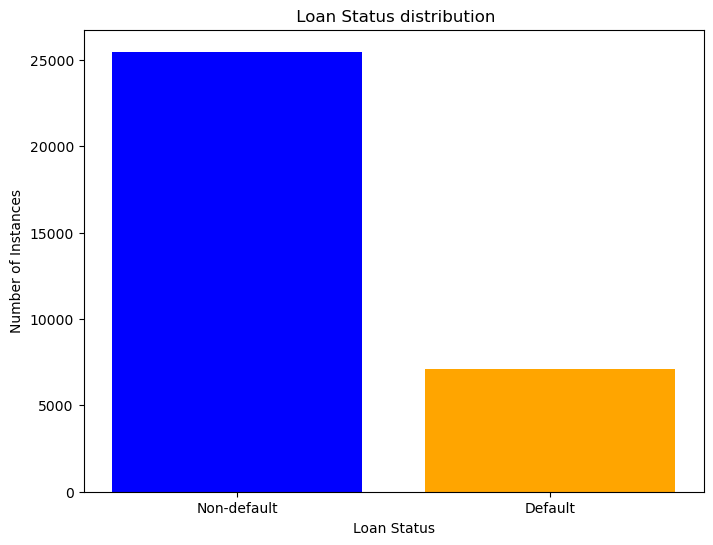

In [19]:
# Check the distribution of the target variable
class_counts = y.value_counts()

print("Class Distribution in the Dataset:")
print(class_counts)

# Visualize the distribution of loan status
plt.figure(figsize=(8, 6))
plt.bar(class_counts.index, class_counts.values, color=["blue", "orange"], tick_label=["Non-default", "Default"])
plt.title(" Loan Status distribution")
plt.xlabel("Loan Status")
plt.ylabel("Number of Instances")
plt.show()



As seen is the bar chart, he dataset had a significant class imbalance, with 25,473 non-defaults compared to only 7,108 defaults.

### Scale Data

In [22]:
from sklearn.preprocessing import StandardScaler

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Prediction

### Model Overview

Logistic regression is a simple and interpretable model designed for binary classification. It predicts probabilities between 0 and 1 and works well with linear relationships between features and the target variable. On the other hand, decision trees classify data by splitting it into branches based on feature thresholds, making them suitable for capturing non-linear relationships. In this project, we compare both models to evaluate their strengths in predicting loan defaults.


### Logistic regression model

In [26]:

# Step 1: Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 2: Train logistic regression model
logistic_model = LogisticRegression(class_weight='balanced', max_iter=1000, solver='lbfgs')
logistic_model.fit(X_train_scaled, y_train)

# Step 3: Predict on test data
y_pred_logistic = logistic_model.predict(X_test_scaled)



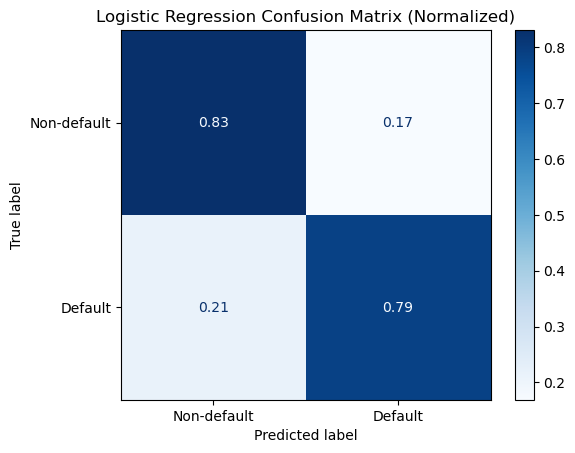

In [27]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# Generate a normalized confusion matrix
cm_normalized = confusion_matrix(y_test, y_pred_logistic, normalize='true')

# Display the normalized confusion matrix
disp_normalized = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=['Non-default', 'Default'])
disp_normalized.plot(cmap="Blues")
plt.title("Logistic Regression Confusion Matrix (Normalized)")
plt.show()

In [28]:

# Print classification report
print("Classification Report for Logistic Regression:")
print(classification_report(y_test, y_pred_logistic))


Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.93      0.83      0.88      7613
           1       0.57      0.79      0.66      2162

    accuracy                           0.82      9775
   macro avg       0.75      0.81      0.77      9775
weighted avg       0.85      0.82      0.83      9775



In [29]:
from sklearn.metrics import f1_score

# Calculate F1-score for the logistic regression model
f1_logistic = f1_score(y_test, y_pred_logistic)
print(f"F1-Score (Logistic Regression): {f1_logistic:.4f}")


F1-Score (Logistic Regression): 0.6601


The classification report shows that the logistic regression model performed well in identifying non-defaults, with a recall of of 81%, but struggled with precision for default, achieving only 54%. The F1 score of 64% confirm the imbalance we observed bewtween the classes in the EDA

### Decision tree Model

In [32]:
# Train decision tree model
tree_model = DecisionTreeClassifier(max_depth=5, random_state=42)
tree_model.fit(X_train, y_train)

# Predict using decision tree
y_pred_tree = tree_model.predict(X_test)

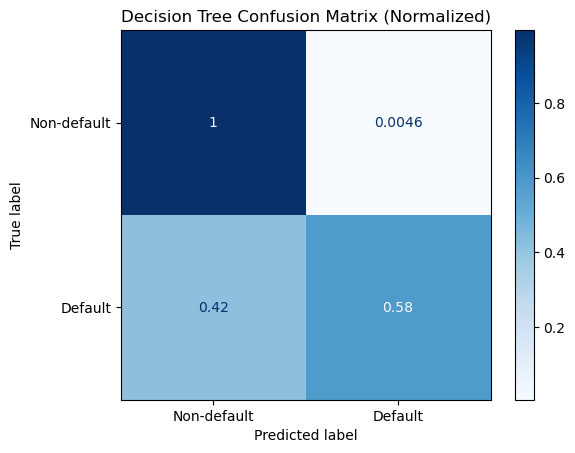

In [33]:
# Generate a normalized confusion matrix for the decision tree
cm_tree_normalized = confusion_matrix(y_test, y_pred_tree, normalize='true')

# Display the normalized confusion matrix
disp_tree_normalized = ConfusionMatrixDisplay(confusion_matrix=cm_tree_normalized, display_labels=['Non-default', 'Default'])
disp_tree_normalized.plot(cmap="Blues")
plt.title("Decision Tree Confusion Matrix (Normalized)")
plt.show()

In [34]:
print("Classification Report for Decision Tree:")
print(classification_report(y_test, y_pred_tree))

Classification Report for Decision Tree:
              precision    recall  f1-score   support

           0       0.89      1.00      0.94      7613
           1       0.97      0.58      0.73      2162

    accuracy                           0.90      9775
   macro avg       0.93      0.79      0.84      9775
weighted avg       0.91      0.90      0.90      9775



In [35]:
# Calculate F1-score for the decision tree model
f1_tree = f1_score(y_test, y_pred_tree)
print(f"F1-Score (Decision Tree): {f1_tree:.4f}")

F1-Score (Decision Tree): 0.7304


The classification report shows that the decsion tree model performed very well in identifying non-defaults with a recall of 100%, meaning it identified all non default cases. However the model acheived a recall of 58% and a precision of 97% for predicting defaults, resulting in an F1-score of 0.73. While it performs well in correctly identifying defaults among predicted cases, its lower recall indicates it misses a significant portion of actual defaults, highlighting a trade-off in its performance.

# Results


The dataset had a significant class imbalance, with 25,473 non-defaults and only 7,108 defaults, making it challenging to build a model that accurately predicts defaults without favoring non-defaults. 

The decision tree performed better overall, with a weighted F1-score of 0.90 compared to 0.82 for logistic regression. It excelled in precision for defaults (97%) and non-defaults (89%) but struggled with recall for defaults (58%). Logistic regression, on the other hand, achieved higher recall for defaults (78%) but lower precision (54%), making it a better choice if capturing defaults is prioritized over avoiding false positives